In this file I identify the best performing architecture for the Pb concentration model. 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
import time
import shap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap


### Import dataset

In [37]:
with open('../../Data/WOD_Pb_dataset-cleanedSOPbconc.csv', mode='r', newline='') as csvfile:
    WOD_pb_dataset = pd.read_csv(csvfile)
WOD_pb_dataset

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,...,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,...,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
1,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,...,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
2,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,...,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
3,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,...,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
4,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,...,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,...,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
9941,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,...,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
9942,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,...,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
9943,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,...,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


In [38]:
WOD_pb_dataset.isnull().sum()

Cruise                             0
WOD_depth                          0
WOD_latitude [degrees_north]       0
WOD_longitude [degrees_east]       0
Pb_CONC [pmol/kg]                 25
Pb_206_207                      7931
Pb_208_207                      7935
Ocean_basin                        0
Salinity                           0
Temperature                        0
Silicate                           0
Nitrate                            0
Phosphate                          0
Oxygen                             0
AOU                                0
MLD                                0
Sigma                              0
Chlorophyll-a                      0
Black Carbon AOD                   0
Dust AOD                           0
Bottom_distance                    0
dtype: int64

### Analyse and clean dataset for Pb concentration model

##### Drop rows with no Pb concentration data

In [39]:
pb_conc_dataset = WOD_pb_dataset.dropna(subset = ['Pb_CONC [pmol/kg]'])
len(pb_conc_dataset)

9920

##### Make copy of dataset for reference

In [40]:
pb_conc_dataset_ref = pb_conc_dataset.copy()
pb_conc_dataset_ref

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,...,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,...,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
1,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,...,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
2,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,...,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
3,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,...,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
4,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,...,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,...,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
9941,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,...,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
9942,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,...,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
9943,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,...,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


##### Analyse geographic sample distribution

In [41]:
pb_conc_dataset['Ocean_basin'].value_counts()

Ocean_basin
Pacific     3796
Atlantic    3185
Southern    1621
Arctic       756
Indian       562
Name: count, dtype: int64

In [42]:
pb_conc_dataset.drop(['Ocean_basin'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### Plot sample distribution

Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".


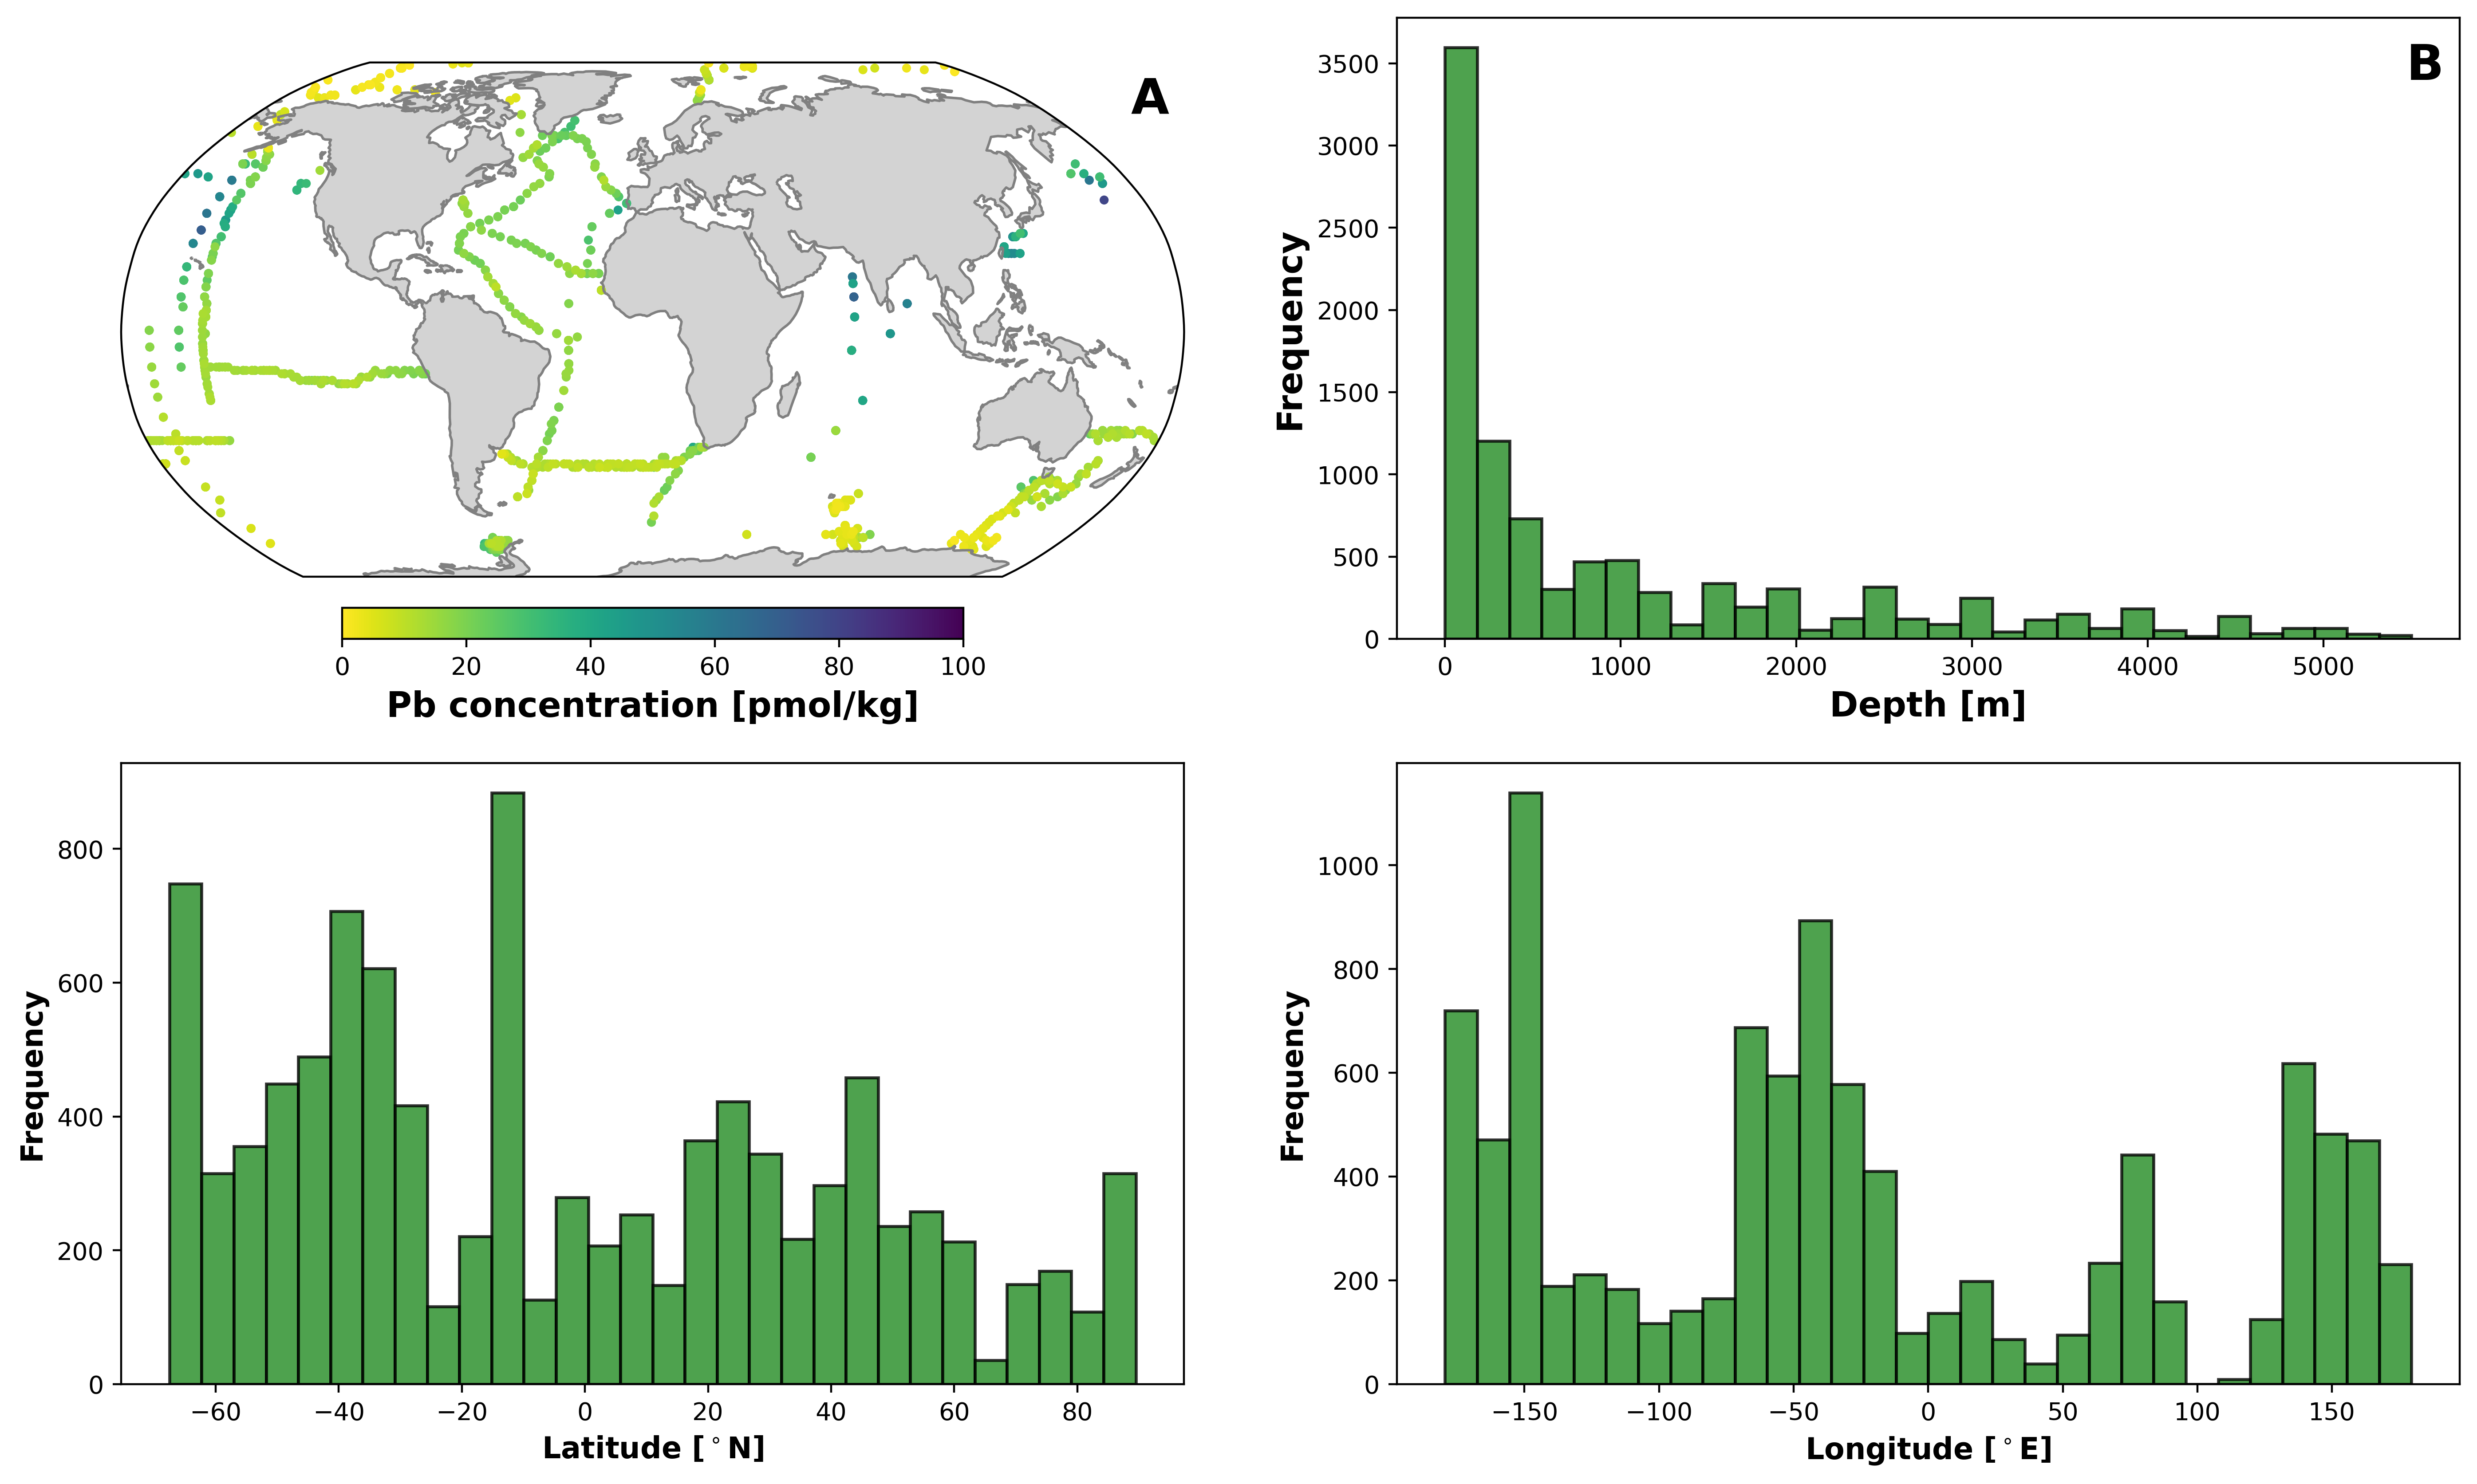

In [10]:
fig = plt.figure(figsize=(17,10), dpi = 400)

ax1 = fig.add_subplot(221, projection=ccrs.Robinson())
cs = ax1.scatter(pb_conc_dataset[pb_conc_dataset['WOD_depth'] < 100]['WOD_longitude [degrees_east]'], pb_conc_dataset[pb_conc_dataset['WOD_depth'] < 100]['WOD_latitude [degrees_north]'], c = pb_conc_dataset[pb_conc_dataset['WOD_depth'] < 100]['Pb_CONC [pmol/kg]'], cmap = 'viridis_r', vmin =0, vmax = 100, s = 7, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, color='lightgrey')
ax1.add_feature(cfeature.COASTLINE, color = 'grey')
ax1.text(0.95, 0.90, 'A', fontweight='bold', fontsize = 20, transform=ax1.transAxes)
plt.colorbar(cs, orientation = 'horizontal', fraction = 0.05, pad = 0.05).set_label(label = 'Pb concentration [pmol/kg]', fontsize = 14, fontweight = 'bold')
ax2 = plt.subplot(222)
ax2.hist(pb_conc_dataset['WOD_depth'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha=0.8, linewidth = 1.2);
ax2.set_xlabel('Depth [m]', fontsize = 14, fontweight = 'bold')
ax2.set_ylabel('Frequency', fontsize = 14, fontweight = 'bold')
ax2.text(0.95, 0.90, 'B', fontweight='bold', fontsize = 20, transform=ax2.transAxes)
ax3 = plt.subplot(223)
ax3.hist(pb_conc_dataset['WOD_latitude [degrees_north]'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha=0.8, linewidth = 1.2);
ax3.set_xlabel('Latitude [$^\circ$N]', fontsize = 12, fontweight = 'bold')
ax3.set_ylabel('Frequency', fontsize = 12, fontweight = 'bold')
ax4 = plt.subplot(224)
ax4.hist(pb_conc_dataset['WOD_longitude [degrees_east]'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha=0.8, linewidth = 1.2);
ax4.set_xlabel('Longitude [$^\circ$E]', fontsize = 12, fontweight = 'bold')
ax4.set_ylabel('Frequency', fontsize = 12, fontweight = 'bold')


plt.savefig('../../Figures/For_ms/Pb_conc_observations.png', dpi = 400)

#plt.tight_layout

## Model Pb concentration

##### Split train and test datasets

In [11]:
idx_1 = pb_conc_dataset[(pb_conc_dataset['Cruise'] == 'GA03') & (pb_conc_dataset['WOD_latitude [degrees_north]'] < 30) & (pb_conc_dataset['WOD_latitude [degrees_north]'] > 10) & (pb_conc_dataset['WOD_longitude [degrees_east]'] > -65) & (pb_conc_dataset['WOD_longitude [degrees_east]'] < -30)].index

test_geo_NA = pb_conc_dataset.loc[idx_1]
test_geo_NA

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
83,GA03,800,24.5,-40.5,63.799999,NaN,NaN,35.291,9.118,14.328,23.598,1.485,152.389,130.331,68.263,30.973,0.066663,0.003942,0.036253,3814
159,GA03,700,22.5,-35.5,57.950001,1.1847,2.4471,35.344,9.771,13.436,23.817,1.493,141.176,136.294,62.866,30.439,0.066932,0.004812,0.065210,5152
175,GA03,800,22.5,-35.5,56.599998,1.1837,2.4476,35.189,8.401,16.604,26.539,1.693,138.673,146.634,62.866,31.010,0.066932,0.004812,0.065210,5052
196,GA03,600,22.5,-35.5,54.799999,1.1842,2.4469,35.527,11.269,9.455,20.440,1.233,148.932,117.819,62.866,29.856,0.066932,0.004812,0.065210,5252
222,GA03,950,24.5,-40.5,53.000000,NaN,NaN,35.119,7.327,17.883,25.523,1.620,160.561,132.750,68.263,31.817,0.066663,0.003942,0.036253,3664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7734,GA03,5100,29.5,-56.5,7.500000,1.1880,2.4591,34.857,2.096,50.514,22.139,1.521,251.278,84.458,57.941,51.012,0.087021,0.004251,0.015502,699
7769,GA03,3300,26.5,-44.5,7.400000,1.1910,2.4545,34.922,2.660,36.211,20.447,1.381,249.574,78.964,68.652,43.019,0.066036,0.003805,0.025563,587
7770,GA03,3400,26.5,-44.5,7.400000,1.1819,2.4516,34.921,2.645,36.680,20.398,1.387,249.443,79.100,68.652,43.468,0.066036,0.003805,0.025563,487
8006,GA03,3300,26.5,-44.5,6.700000,1.1863,2.4524,34.922,2.660,36.211,20.447,1.381,249.574,78.964,68.652,43.019,0.066036,0.003805,0.025563,587


In [12]:
dataset = pb_conc_dataset.drop(idx_1)
dataset

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA03,650,17.5,-20.5,95.000000,NaN,NaN,35.032,8.381,19.759,34.914,2.151,79.615,207.567,33.403,30.234,0.295629,0.008788,0.228192,2707
1,GPpr08,300,-66.5,-73.5,86.694832,NaN,NaN,34.645,1.734,86.885,33.177,2.165,185.200,150.737,74.541,29.117,0.367175,0.000814,0.000046,3322
2,GPc06,100,35.5,-160.5,85.008240,NaN,NaN,34.283,13.565,6.976,3.114,0.432,251.118,7.351,59.093,26.234,0.151482,0.007072,0.003703,5672
3,GPpr08,20,-64.5,-64.5,83.451134,NaN,NaN,33.844,-0.577,64.359,24.393,1.759,353.124,8.195,64.647,27.335,1.273128,0.000883,0.000057,665
4,GPc06,150,35.5,-160.5,83.258492,NaN,NaN,34.277,12.687,9.814,6.719,0.630,241.757,24.696,59.093,26.638,0.151482,0.007072,0.003703,5622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9915,GP16,2700,-11.5,-128.5,0.200000,NaN,NaN,34.676,1.787,136.520,35.919,2.565,148.027,186.850,67.409,40.259,0.143903,0.003710,0.000711,1308
9916,GP16,3000,-11.5,-128.5,0.200000,1.1812,2.4509,34.681,1.691,135.595,35.448,2.531,156.276,179.789,67.409,41.635,0.143903,0.003710,0.000711,1008
9917,GP16,2700,-11.5,-132.5,0.200000,NaN,NaN,34.676,1.780,137.505,35.943,2.523,148.666,187.614,65.511,40.260,0.140763,0.003627,0.000678,1470
9918,GP16,2800,-11.5,-132.5,0.200000,1.1736,2.4412,34.678,1.752,137.379,35.808,2.513,151.318,185.122,65.511,40.719,0.140763,0.003627,0.000678,1370


In [13]:
y_test_geo_NA = test_geo_NA['Pb_CONC [pmol/kg]']
X_test_geo_NA = test_geo_NA.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [14]:
y = dataset['Pb_CONC [pmol/kg]']
X = dataset.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
#print((len(X_test) + len(X_test_geo_NA))/len(pb_conc_dataset))


facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".


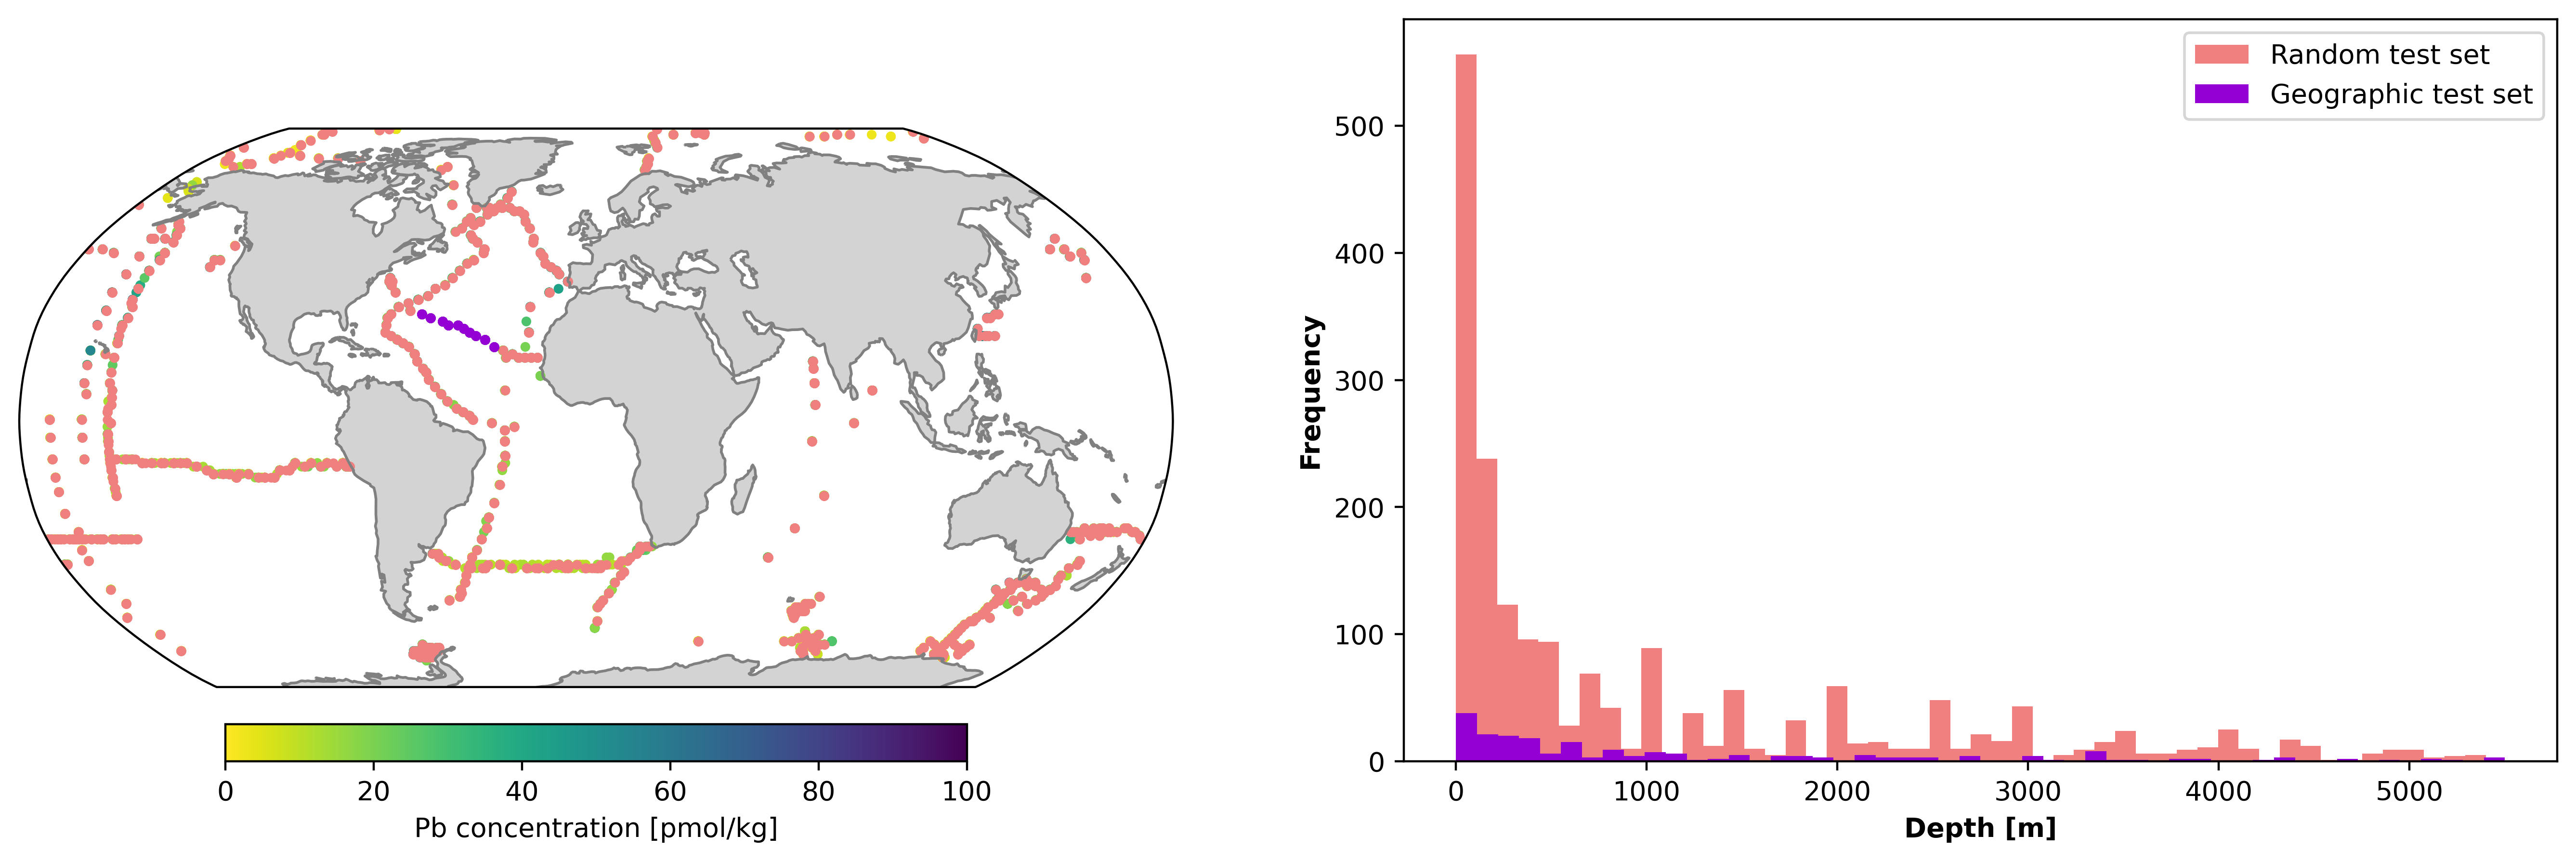

In [16]:
fig = plt.figure(figsize=(17,5), dpi = 400)

ax1 = fig.add_subplot(121, projection=ccrs.Robinson())
cs = ax1.scatter(X_train['WOD_longitude [degrees_east]'], X_train['WOD_latitude [degrees_north]'], c = y_train, cmap = ListedColormap(sns.color_palette('viridis_r', 256)), vmin =0, vmax = 100, s = 7, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, color='lightgrey')
ax1.add_feature(cfeature.COASTLINE, color = 'grey')
plt.colorbar(cs, orientation = 'horizontal', fraction = 0.05, pad = 0.05, label = 'Pb concentration [pmol/kg]')
ax1.scatter(X_test['WOD_longitude [degrees_east]'], X_test['WOD_latitude [degrees_north]'], c = 'lightcoral', s = 7, transform=ccrs.PlateCarree())
ax1.scatter(X_test_geo_NA['WOD_longitude [degrees_east]'], X_test_geo_NA['WOD_latitude [degrees_north]'], c = 'darkviolet', s = 7, transform=ccrs.PlateCarree())

ax2 = fig.add_subplot(122)
ax2.hist(X_test['WOD_depth'], bins = 50, color='lightcoral', label='Random test set')
ax2.hist(X_test_geo_NA['WOD_depth'], bins=50, color='darkviolet', label='Geographic test set')
ax2.legend()
ax2.set_xlabel('Depth [m]', fontweight = 'bold')
ax2.set_ylabel('Frequency', fontweight = 'bold')

plt.savefig('../../Figures/For_ms/Pb_conc_test_split.png', dpi = 400)

<Axes: >

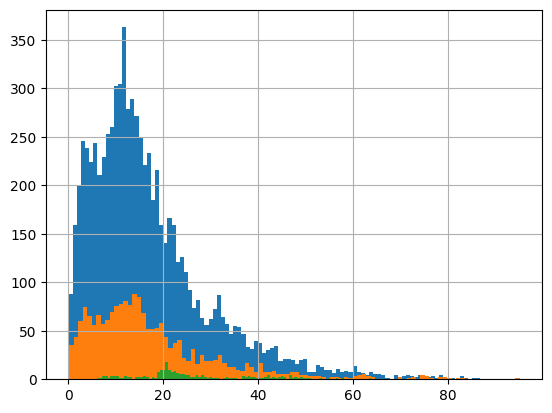

In [17]:
y_train.hist(bins=100)
y_test.hist(bins=100)
y_test_geo_NA.hist(bins=100)

##### Drop coordinates

In [18]:
for data in [X_train, X_test, X_test_geo_NA]:
    data.drop(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]'], axis=1, inplace=True)

##### EDA

In [19]:
num_cols = X_train.select_dtypes(include=np.number).columns

array([[<Axes: title={'center': 'WOD_depth'}>,
        <Axes: title={'center': 'Salinity'}>,
        <Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Silicate'}>],
       [<Axes: title={'center': 'Nitrate'}>,
        <Axes: title={'center': 'Phosphate'}>,
        <Axes: title={'center': 'Oxygen'}>,
        <Axes: title={'center': 'AOU'}>],
       [<Axes: title={'center': 'MLD'}>,
        <Axes: title={'center': 'Sigma'}>,
        <Axes: title={'center': 'Chlorophyll-a'}>,
        <Axes: title={'center': 'Black Carbon AOD'}>],
       [<Axes: title={'center': 'Dust AOD'}>,
        <Axes: title={'center': 'Bottom_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

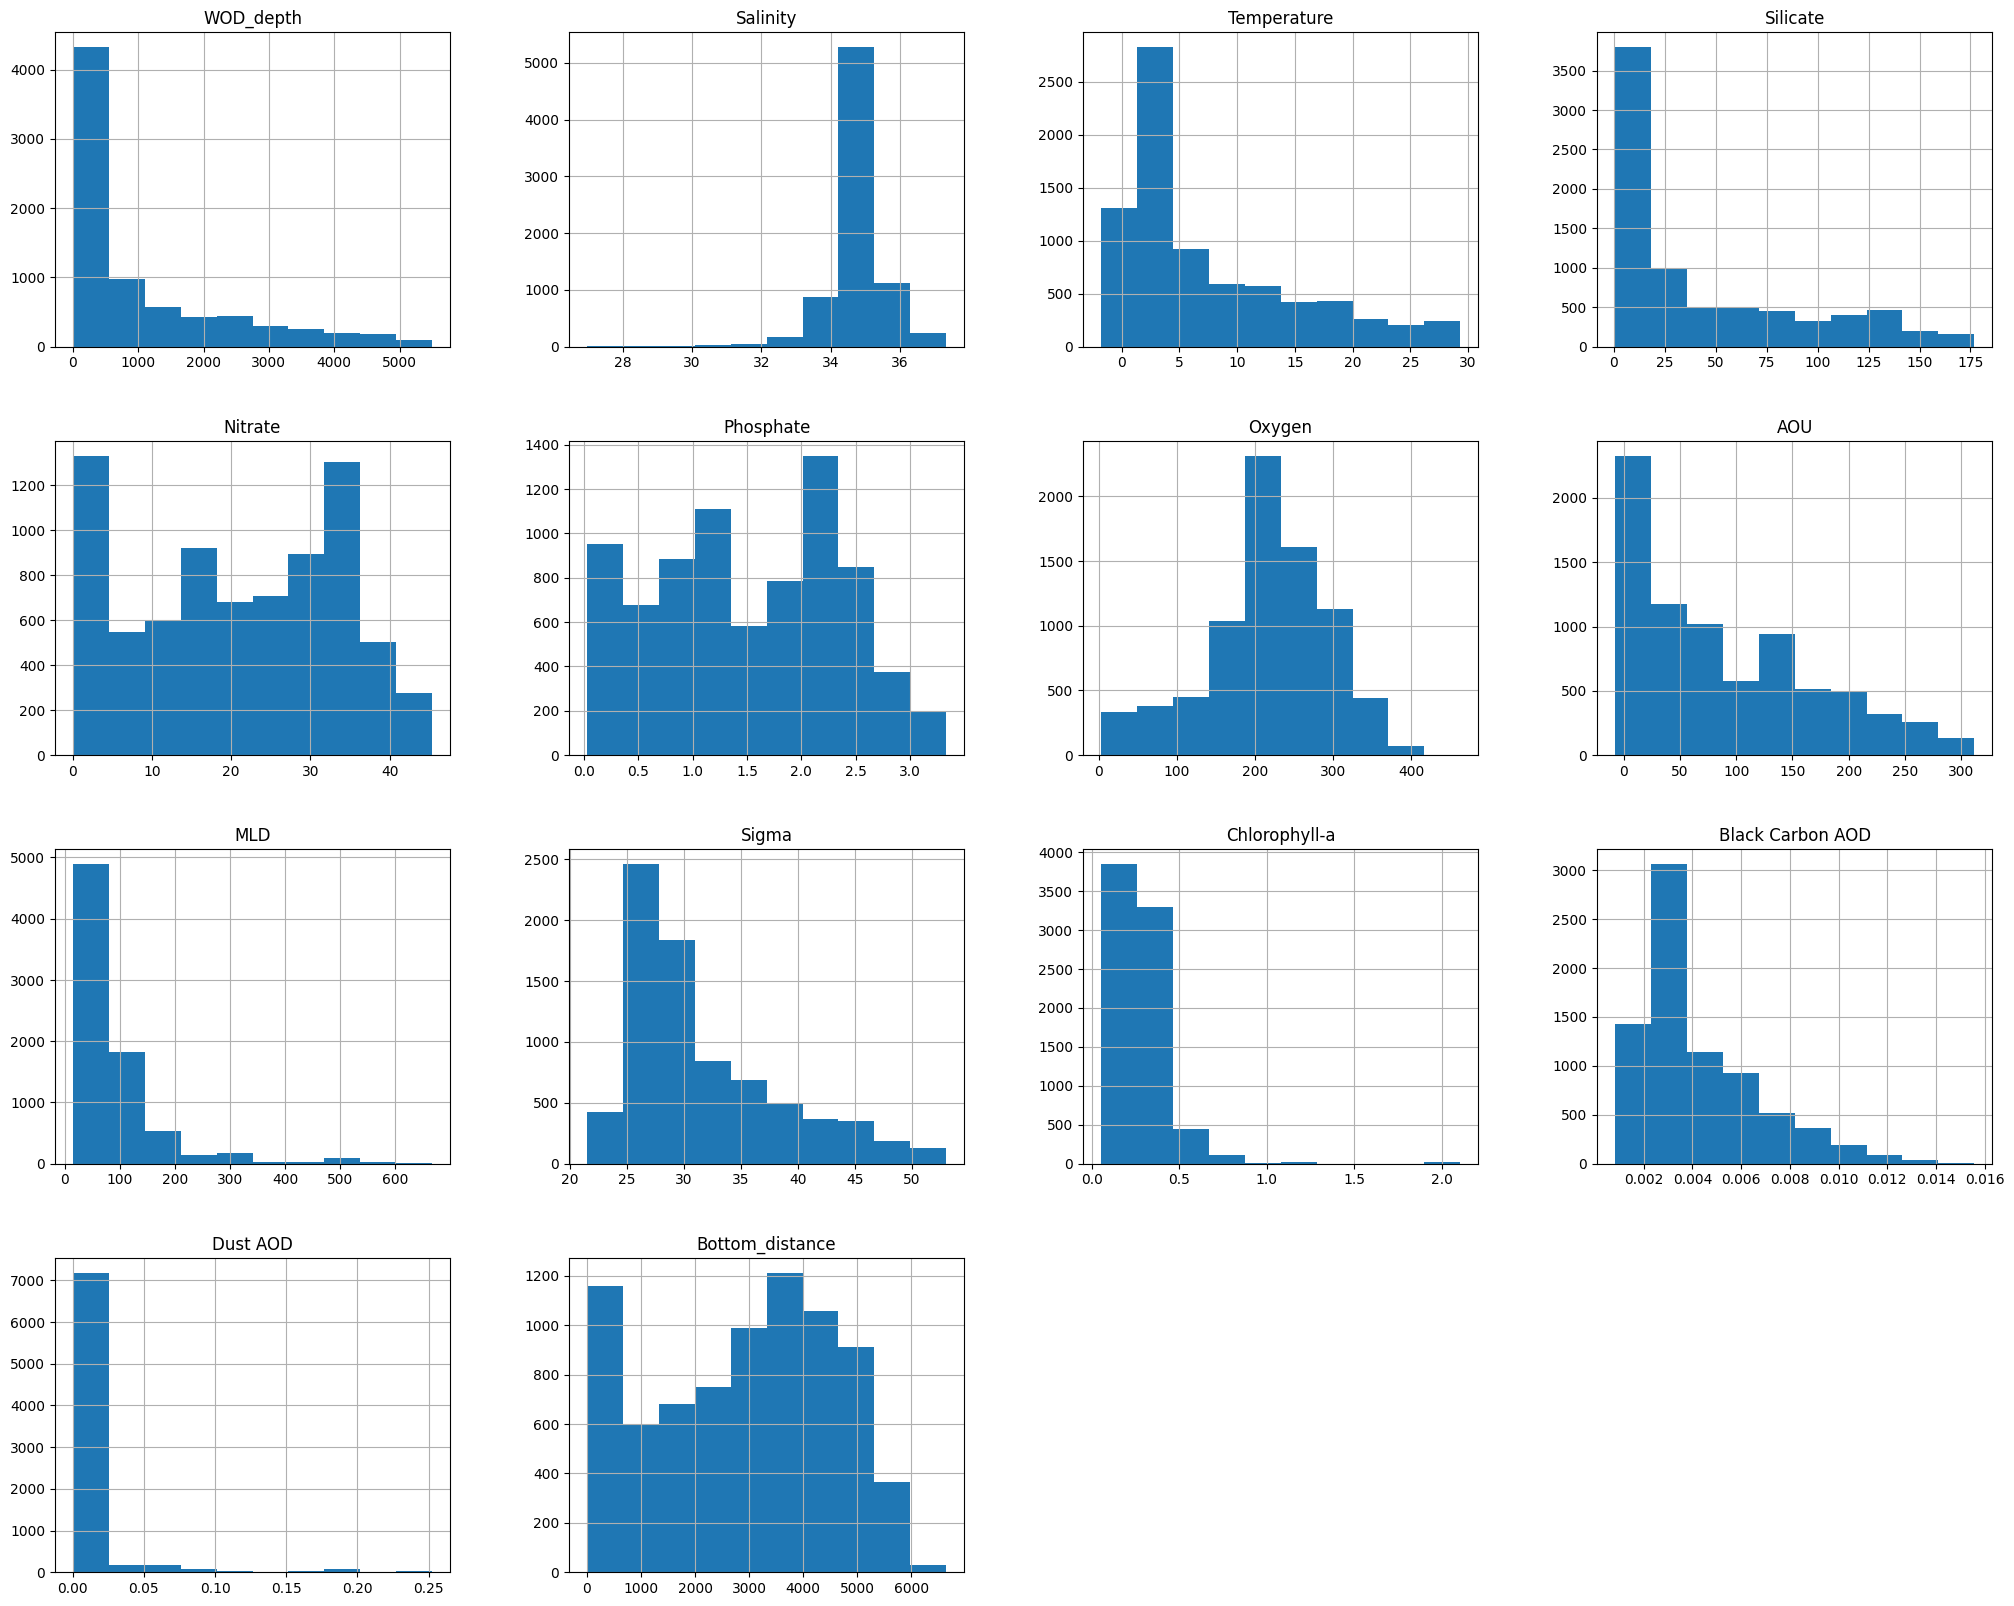

In [44]:
X_train[num_cols].hist(figsize=(25,20))

<Axes: >

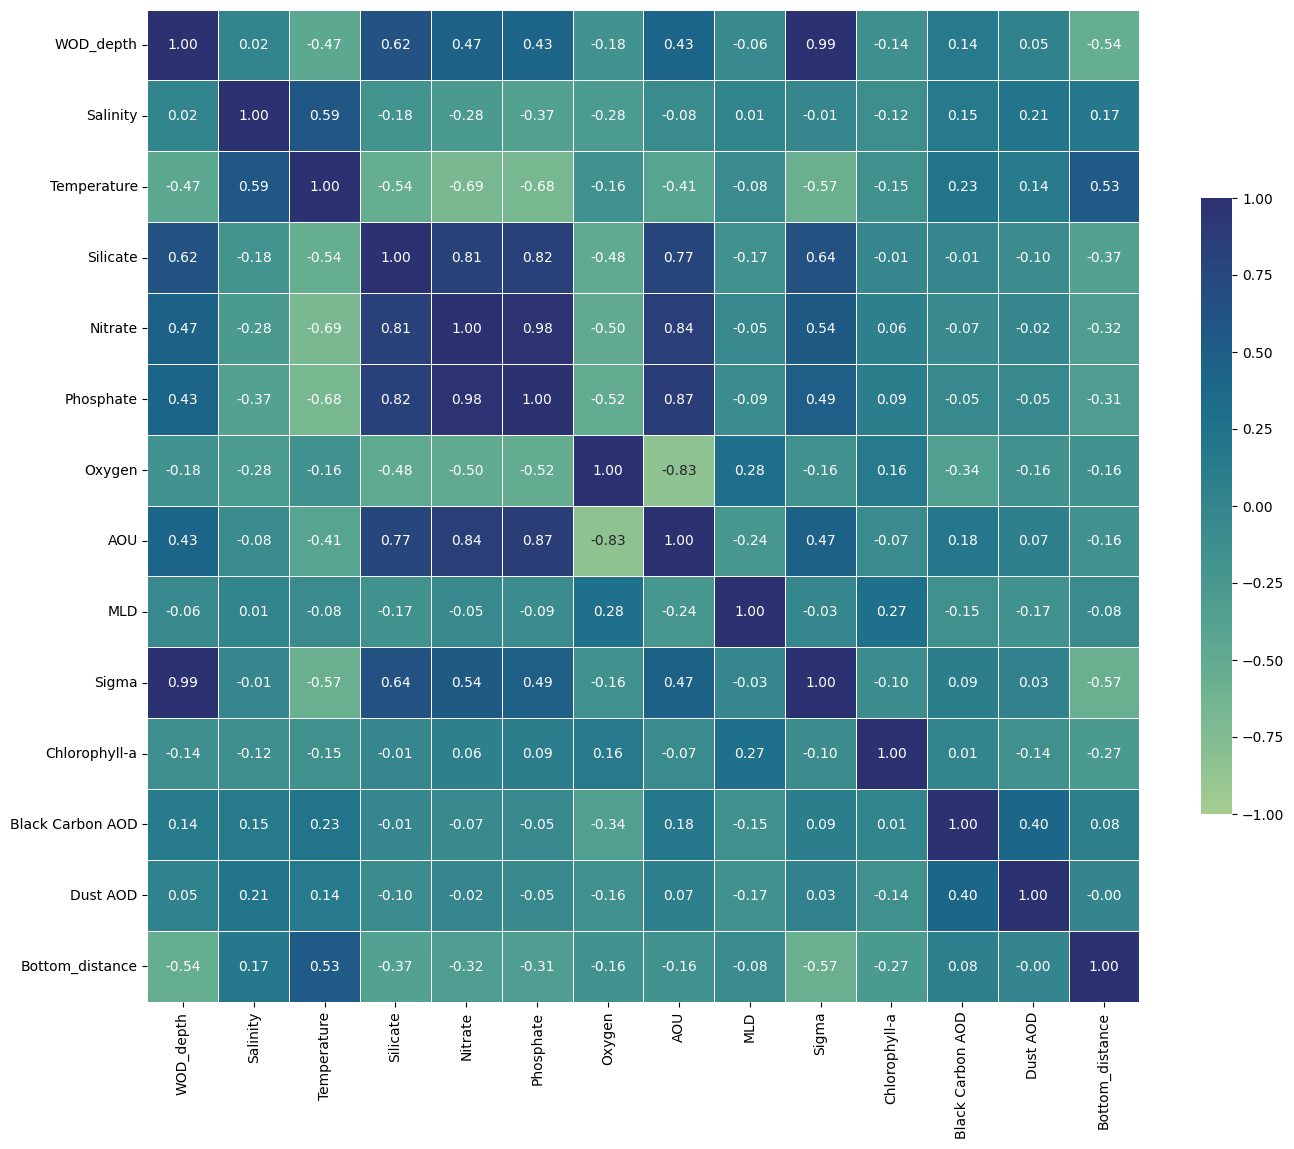

In [21]:
corr = X_train[num_cols].corr()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1, square=True, linewidths=.5, fmt='.2f', annot_kws={'size': 10}, cbar_kws={"shrink": .5})

## <strong style = "color:cyan"> Dummy model </strong>

In [45]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)

y_pred_dummy = dummy_reg.predict(X_test)


In [46]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

print('RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_dummy))

RMSE: 13.61925054528281 R2: -0.000817506104992427


Text(0.05, 0.83, 'n = 1941')

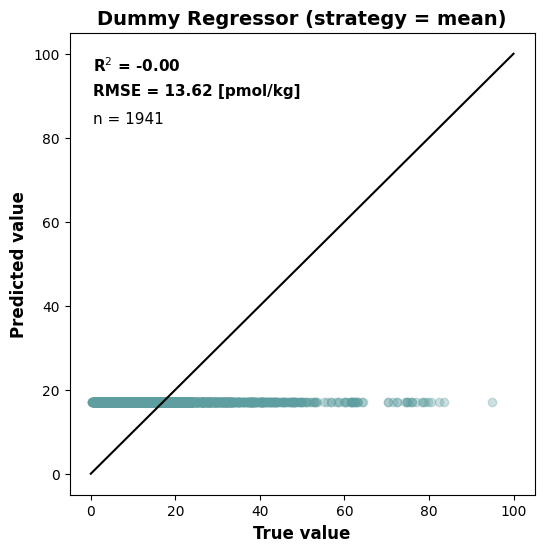

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_test, y_pred_dummy, c='cadetblue', alpha=0.3)
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='black')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('Dummy Regressor (strategy = mean)', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred_dummy):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

In [48]:
print('The average Pb concentration in our testing set is:', y_test.mean())

The average Pb concentration in our testing set is: 17.448107476326634


## <strong style = "color:cyan"> Linear Regression </strong>

In [26]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

num_pipe = make_pipeline(MinMaxScaler())

num_cols = X_train.select_dtypes(include=np.number).columns
num_pipe.fit(X_train[num_cols])

X_train_scaled = pd.DataFrame(num_pipe.transform(X_train[num_cols]), columns=num_cols)
X_test_scaled = pd.DataFrame(num_pipe.transform(X_test[num_cols]), columns=num_cols)
X_test_geo_NA_scaled = pd.DataFrame(num_pipe.transform(X_test_geo_NA[num_cols]), columns=num_cols)

In [27]:
lin_reg = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print('RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_lin))

RMSE: 10.706626411516204 R2: 0.381479963914652


Text(0.05, 0.83, 'n = 1941')

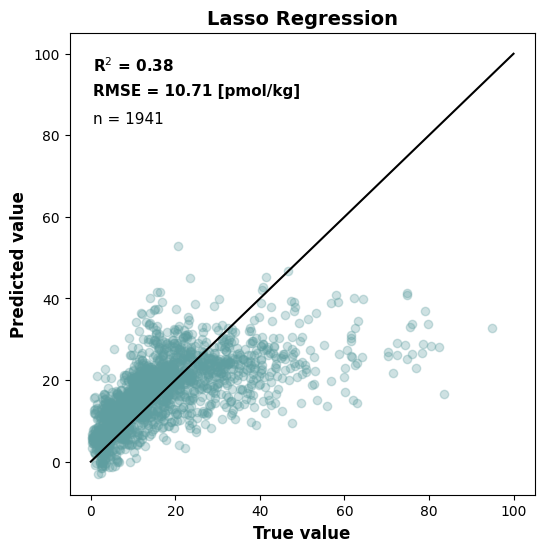

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_test, y_pred_lin, c='cadetblue', alpha=0.3)
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='black')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('Lasso Regression', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred_lin):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

## <strong style = "color:cyan"> Random Forest Regression </strong>

In [29]:
rf_r = RandomForestRegressor(random_state=42)
parameters = {'n_estimators': [400, 600, 800, 1000, 1200], 
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False],
              'max_features': [None, 'sqrt', 'log2']
              }

rf_grid = GridSearchCV(rf_r, 
                       parameters, 
                       cv=5,
                       scoring='neg_mean_absolute_percentage_error',
                       n_jobs=-1, 
                       verbose=1) 

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [400, 600, 800, 1000, 1200]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [30]:
best_rf_model = rf_grid.best_estimator_
best_params = rf_grid.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}


In [31]:
y_pred_rf = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
print('Random test set\n','RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_rf), 'MAPE:', mape)

rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA)))
mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA))
print('Geographic test set\n', 'RMSE:', rmse_geo_NA, 'R2:', r2_score(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA)), 'MAPE:', mape_geo_NA)

Random test set
 RMSE: 5.094474953818097 R2: 0.8599615363841661 MAPE: 0.2070108998342391
Geographic test set
 RMSE: 5.536456073851175 R2: 0.781926402002751 MAPE: 0.2113172348291371


## <strong style = "color:cyan"> XGB Regression </strong>

In [32]:
xgb_r = XGBRegressor(seed = 42)
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.3], #[0.01, 0.05, 0.1, 0.3]
              'n_estimators': [1200, 1300, 1400, 1500, 1600], #[200, 400, 600, 800]
              'max_depth': [12, 14, 16, 18], #[6, 8, 10, 12]
              'colsample_bytree': [0.5, 0.7, 0.9, 1.0], #[0.5, 0.8, 0.9]
              'min_child_weight': [6, 8, 10, 12]}

xgb_grid = GridSearchCV(xgb_r,
                        parameters,
                        cv = 5,
                        scoring='neg_mean_absolute_percentage_error',
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

df_results = pd.DataFrame(xgb_grid.cv_results_)
timestr = time.strftime("%Y%m%d-%H%M%S")
df_results.to_csv('Model_output/XGBoost-cleanedSOPbconc-GridsearchCV_results_{0}.csv'.format(timestr), index=False)
df_results

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.631636,1.804325,0.576671,0.103213,0.5,0.01,12,6,1200,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.214523,-0.191535,-0.225977,-0.229997,-0.209168,-0.214240,0.013619,157
1,43.574655,1.084653,0.610299,0.091376,0.5,0.01,12,6,1300,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.213902,-0.191384,-0.225480,-0.229684,-0.208760,-0.213842,0.013540,139
2,45.869026,1.579924,0.650162,0.133417,0.5,0.01,12,6,1400,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.213463,-0.191277,-0.225337,-0.229276,-0.208603,-0.213591,0.013467,127
3,47.715307,1.490048,0.693198,0.089508,0.5,0.01,12,6,1500,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.213262,-0.191253,-0.225011,-0.229313,-0.208504,-0.213469,0.013435,123
4,49.671675,1.150519,0.854987,0.101887,0.5,0.01,12,6,1600,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.213069,-0.191338,-0.224746,-0.229517,-0.208514,-0.213437,0.013410,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,24.257770,1.515454,0.301452,0.039667,1.0,0.3,18,12,1200,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.230373,-0.222482,-0.255518,-0.253660,-0.234534,-0.239313,0.013073,1082
1276,24.658567,1.670560,0.323724,0.063714,1.0,0.3,18,12,1300,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.230373,-0.222482,-0.255518,-0.253662,-0.234534,-0.239314,0.013073,1083
1277,25.002471,2.369754,0.310050,0.043154,1.0,0.3,18,12,1400,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.230373,-0.222482,-0.255518,-0.253668,-0.234534,-0.239315,0.013075,1085
1278,24.100819,1.566983,0.310644,0.051469,1.0,0.3,18,12,1500,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",-0.230373,-0.222482,-0.255518,-0.253668,-0.234534,-0.239315,0.013075,1084


In [40]:
rmse_test = []
mape_test = []
rmse_test_geo_NA = []
mape_test_geo_NA = []

for i in range(0, len(df_results)):
    print(i)
    model = XGBRegressor(colsample_bytree=df_results['param_colsample_bytree'][i], 
                            learning_rate=df_results['param_learning_rate'][i], 
                            max_depth=df_results['param_max_depth'][i], 
                            min_child_weight=df_results['param_min_child_weight'][i], 
                            n_estimators=df_results['param_n_estimators'][i],
                            early_stopping_rounds=50,
                            eval_metric='mape', 
                            seed=42)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test, iteration_range=(0, model.best_iteration + 1))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    rmse_test.append(rmse)
    mape_test.append(mape)

    y_pred_geo_NA = model.predict(X_test_geo_NA, iteration_range=(0, model.best_iteration + 1))
    rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, y_pred_geo_NA))
    mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, y_pred_geo_NA)

    rmse_test_geo_NA.append(rmse_geo_NA)
    mape_test_geo_NA.append(mape_geo_NA)

df_results['rmse_test'] = rmse_test
df_results['mape_test'] = mape_test
df_results['rmse_test_geo_NA'] = rmse_test_geo_NA
df_results['mape_test_geo_NA'] = mape_test_geo_NA

df_results.to_csv('Model_output/XGBoost-cleanedSOPbconc-GridsearchCV_results_{0}_with-test-performance.csv'.format(timestr), index=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### <strong style = "color:cyan"> XGBoost - best model selection </strong>

In [37]:
model_grid = pd.read_csv('Model_output/XGBoost-cleanedSOPbconc-GridsearchCV_results_20241017-164328_with-test-performance.csv')


In [ ]:
model_grid.sort_values(by='rank_test_score', inplace=True)
model_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,...,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,rmse_test,mape_test,rmse_test_geo_NA,mape_test_geo_NA
348,46.747585,1.543531,0.648125,0.050893,0.7,0.01,14,8,1500,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.222331,-0.227555,-0.207241,-0.210967,0.013443,1,4.836053,0.201924,5.064833,0.18305
347,44.707022,1.589292,0.558011,0.039303,0.7,0.01,14,8,1400,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.222585,-0.227480,-0.207302,-0.210993,0.013545,2,4.836053,0.201924,5.064833,0.18305
349,48.073136,1.848996,0.646580,0.064999,0.7,0.01,14,8,1600,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.222450,-0.227493,-0.207197,-0.211039,0.013332,3,4.836053,0.201924,5.064833,0.18305
346,42.294869,1.582966,0.638621,0.080238,0.7,0.01,14,8,1300,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.222934,-0.227662,-0.207516,-0.211133,0.013657,4,4.836053,0.201924,5.064833,0.18305
345,40.591688,1.366056,0.531702,0.042528,0.7,0.01,14,8,1200,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.223180,-0.227873,-0.207704,-0.211264,0.013740,5,4.836053,0.201924,5.064833,0.18305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,21.122737,0.886204,0.431874,0.080153,0.5,0.30,14,12,1200,"{'colsample_bytree': 0.5, 'learning_rate': 0.3...",...,-0.269658,-0.271787,-0.251281,-0.257936,0.010805,1276,5.144387,0.233395,6.973209,0.25507
276,22.938098,0.723990,0.439183,0.041160,0.5,0.30,14,12,1300,"{'colsample_bytree': 0.5, 'learning_rate': 0.3...",...,-0.269717,-0.271909,-0.251304,-0.258009,0.010810,1277,5.144387,0.233395,6.973209,0.25507
277,25.808736,0.710741,0.463133,0.056139,0.5,0.30,14,12,1400,"{'colsample_bytree': 0.5, 'learning_rate': 0.3...",...,-0.269758,-0.271966,-0.251333,-0.258065,0.010804,1278,5.144387,0.233395,6.973209,0.25507
278,27.408965,0.894043,0.508843,0.059841,0.5,0.30,14,12,1500,"{'colsample_bytree': 0.5, 'learning_rate': 0.3...",...,-0.269796,-0.272039,-0.251373,-0.258113,0.010812,1279,5.144387,0.233395,6.973209,0.25507


In [39]:
model_grid['mape_val']=-model_grid['mean_test_score']

In [40]:
mean_mape_cv = np.mean(model_grid['mape_val'])*100
std2_mape_cv = np.std(model_grid['mape_val'])*2*100
mean_mape_test = np.mean(model_grid['mape_test'])*100
std2_mape_test = np.std(model_grid['mape_test'])*2*100
mean_mape_test_geo_NA = np.mean(model_grid['mape_test_geo_NA'])*100
std2_mape_test_geo_NA = np.std(model_grid['mape_test_geo_NA'])*2*100

print('Mean MAPE CV:', mean_mape_cv, '+/-', std2_mape_cv)
print('Mean MAPE test:', mean_mape_test, '+/-', std2_mape_test)
print('Mean MAPE test geo NA:', mean_mape_test_geo_NA, '+/-', std2_mape_test_geo_NA)

Mean MAPE CV: 22.721166227130958 +/- 2.2184461879870754
Mean MAPE test: 20.718752199976347 +/- 1.4943727859243492
Mean MAPE test geo NA: 19.468451152915726 +/- 4.065646459484021


In [41]:
model_grid.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,...,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,rmse_test,mape_test,rmse_test_geo_NA,mape_test_geo_NA,mape_val
348,46.747585,1.543531,0.648125,0.050893,0.7,0.01,14,8,1500,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.227555,-0.207241,-0.210967,0.013443,1,4.836053,0.201924,5.064833,0.183050,0.210967
347,44.707022,1.589292,0.558011,0.039303,0.7,0.01,14,8,1400,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.227480,-0.207302,-0.210993,0.013545,2,4.836053,0.201924,5.064833,0.183050,0.210993
349,48.073136,1.848996,0.646580,0.064999,0.7,0.01,14,8,1600,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.227493,-0.207197,-0.211039,0.013332,3,4.836053,0.201924,5.064833,0.183050,0.211039
346,42.294869,1.582966,0.638621,0.080238,0.7,0.01,14,8,1300,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.227662,-0.207516,-0.211133,0.013657,4,4.836053,0.201924,5.064833,0.183050,0.211133
345,40.591688,1.366056,0.531702,0.042528,0.7,0.01,14,8,1200,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.227873,-0.207704,-0.211264,0.013740,5,4.836053,0.201924,5.064833,0.183050,0.211264
374,52.583425,2.568212,0.786611,0.127011,0.7,0.01,16,10,1600,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.230213,-0.207558,-0.211294,0.013950,6,4.859026,0.201521,5.048381,0.180658,0.211294
329,36.257674,1.245355,0.530464,0.034411,0.7,0.01,12,8,1600,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.226310,-0.208029,-0.211334,0.013351,7,4.820621,0.200237,5.181677,0.188887,0.211334
373,44.117700,1.962522,0.700197,0.109236,0.7,0.01,16,10,1500,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.230366,-0.207770,-0.211349,0.014077,8,4.859026,0.201521,5.048381,0.180658,0.211349
372,41.847663,1.527651,0.586477,0.043849,0.7,0.01,16,10,1400,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.230358,-0.207970,-0.211388,0.014103,9,4.859026,0.201521,5.048381,0.180658,0.211388
324,43.571613,1.191258,0.577569,0.027899,0.7,0.01,12,6,1600,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",...,-0.226704,-0.206164,-0.211403,0.012900,10,4.830871,0.199323,5.118370,0.184850,0.211403


In [42]:
best_xgb_model = XGBRegressor(colsample_bytree=model_grid['param_colsample_bytree'].to_numpy()[0], 
                              learning_rate=model_grid['param_learning_rate'].to_numpy()[0], 
                              max_depth=model_grid['param_max_depth'].to_numpy()[0], 
                              min_child_weight=model_grid['param_min_child_weight'].to_numpy()[0], 
                              n_estimators=model_grid['param_n_estimators'].to_numpy()[0], 
                              early_stopping_rounds=50,
                              eval_metric = 'mape',
                              seed=42)

best_xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-mape:1.53317	validation_1-mape:1.59387
[1]	validation_0-mape:1.51943	validation_1-mape:1.57996
[2]	validation_0-mape:1.50584	validation_1-mape:1.56611
[3]	validation_0-mape:1.49276	validation_1-mape:1.55279
[4]	validation_0-mape:1.47959	validation_1-mape:1.53951
[5]	validation_0-mape:1.46631	validation_1-mape:1.52584
[6]	validation_0-mape:1.45324	validation_1-mape:1.51252
[7]	validation_0-mape:1.44047	validation_1-mape:1.49984
[8]	validation_0-mape:1.42757	validation_1-mape:1.48655
[9]	validation_0-mape:1.41498	validation_1-mape:1.47382
[10]	validation_0-mape:1.40259	validation_1-mape:1.46129
[11]	validation_0-mape:1.39007	validation_1-mape:1.44841
[12]	validation_0-mape:1.37777	validation_1-mape:1.43589
[13]	validation_0-mape:1.36567	validation_1-mape:1.42364
[14]	validation_0-mape:1.35370	validation_1-mape:1.41152
[15]	validation_0-mape:1.34182	validation_1-mape:1.39945
[16]	validation_0-mape:1.32995	validation_1-mape:1.38744
[17]	validation_0-mape:1.31878	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
best_xgb_model.best_iteration

1191

In [44]:
model_grid.rename(columns={'param_colsample_bytree': 'Columns Sampled by Tree', 'param_learning_rate': 'Learning Rate', 'param_max_depth': 'Maximum Depth', 'param_min_child_weight': 'Minimum Child Weight', 'param_n_estimators': 'Number of Trees'}, inplace=True)

<Figure size 3000x3000 with 0 Axes>

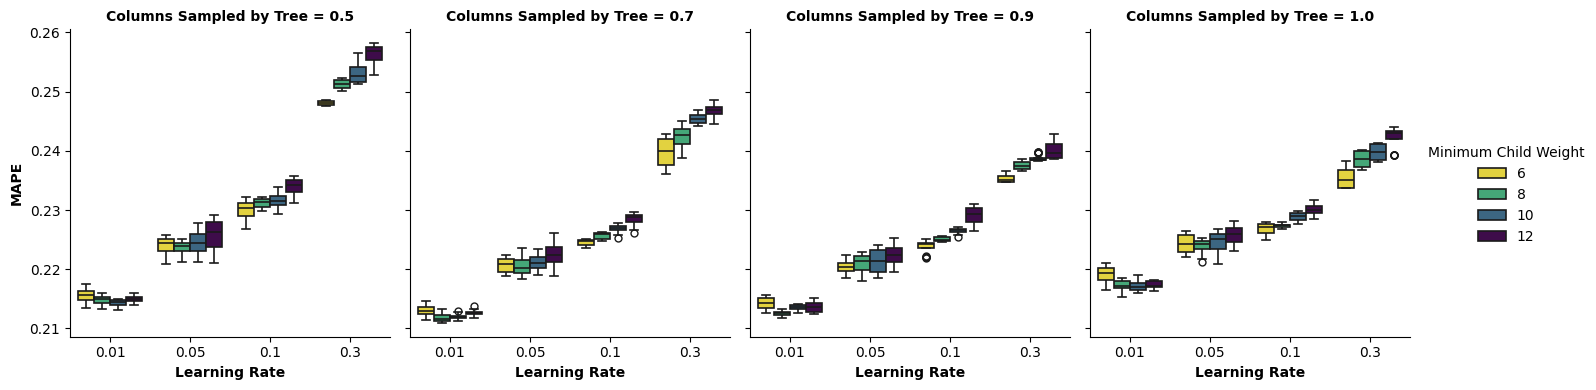

In [45]:
plt.figure(figsize=(10,10), dpi=300)
cat_plt = sns.catplot(x=model_grid['Learning Rate'], y=model_grid['mape_val'], hue=model_grid['Minimum Child Weight'], col=model_grid['Columns Sampled by Tree'], kind="box", height=4, aspect=.9, linewidth=1.2, palette='viridis_r')
cat_plt.set_xlabels(fontweight='bold')
cat_plt.set_ylabels(label='MAPE', fontweight='bold')
cat_plt.set_titles(fontweight='bold')
plt.savefig('../../Figures/For_ms/XGBoost-Pb-conc_GridsearchCV_results-catplot.png', dpi = 400)

In [46]:
y_pred = best_xgb_model.predict(X_test, iteration_range=(0, best_xgb_model.best_iteration + 1))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RMSE:', rmse, 'MAPE:', mape, 'R2:', r2_score(y_test, y_pred))

RMSE: 4.836053033128184 MAPE: 0.20192368949220388 R2: 0.8738083601318838


Text(0.05, 0.83, 'n = 1941')

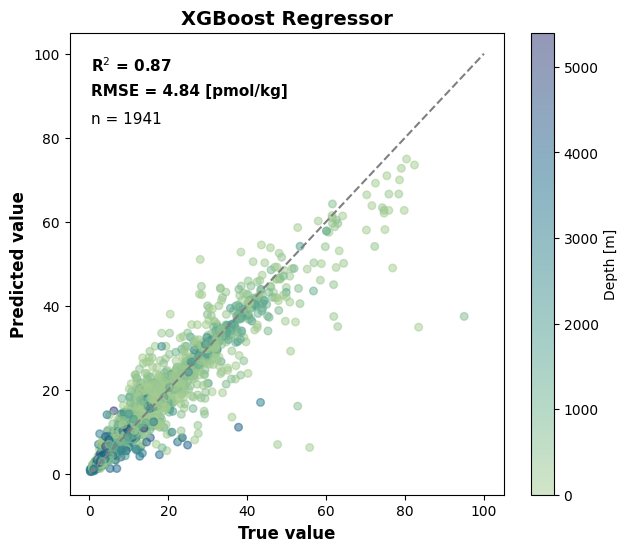

In [47]:
fig, ax = plt.subplots(1,1, figsize=(7,6))
c = ax.scatter(y_test, y_pred, c=X_test['WOD_depth'], cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=0.5, s=30)
fig.colorbar(c, label = 'Depth [m]')
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_prediction-coldepth.png', dpi = 400)

Text(0.05, 0.83, 'n = 1941')

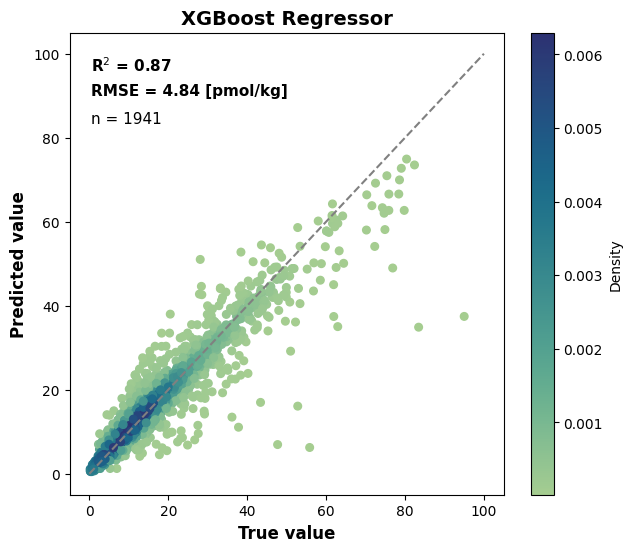

In [48]:
from scipy.stats import gaussian_kde

xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(1,1, figsize=(7, 6))
c = ax.scatter(y_test, y_pred, c=z, cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=1, s=30)
fig.colorbar(c, label='Density')
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_prediction-coldensity.png', dpi = 400)

In [49]:
y_pred_geo_NA = best_xgb_model.predict(X_test_geo_NA, iteration_range=(0, best_xgb_model.best_iteration + 1))
rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, y_pred_geo_NA))
mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, y_pred_geo_NA)
print('RMSE:', rmse_geo_NA, 'MAPE:', mape_geo_NA, 'R2:', r2_score(y_test_geo_NA, y_pred_geo_NA))

RMSE: 5.064833385658936 MAPE: 0.18305042855906423 R2: 0.817497130031253


Text(0.05, 0.83, 'n = 216')

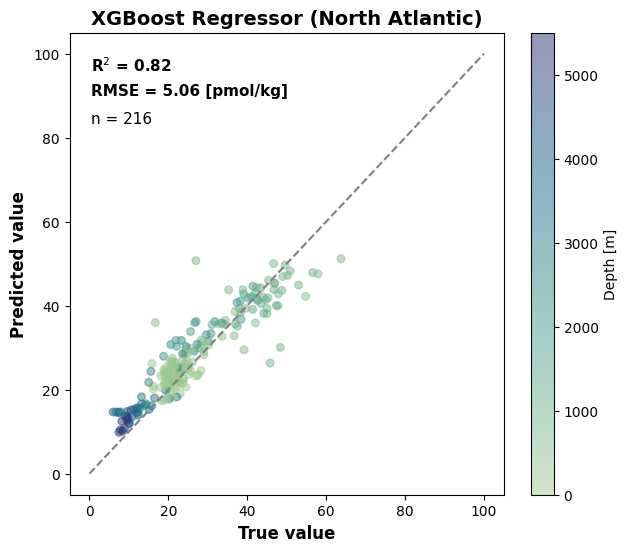

In [50]:
fig, ax = plt.subplots(1,1, figsize=(7,6))
c = ax.scatter(y_test_geo_NA, y_pred_geo_NA, c=X_test_geo_NA['WOD_depth'], cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=0.5, s=30)
fig.colorbar(c, label='Depth [m]')
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor (North Atlantic)', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test_geo_NA, y_pred_geo_NA):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse_geo_NA:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test_geo_NA)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_NAprediction-coldepth.png', dpi = 400)

Text(0.05, 0.83, 'n = 216')

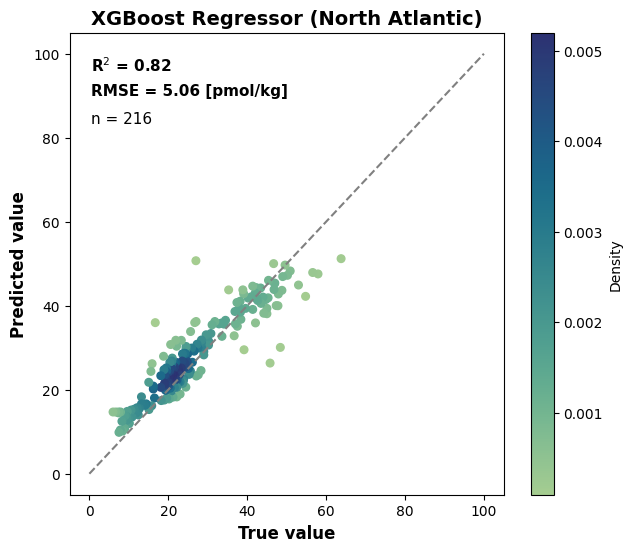

In [51]:
xy = np.vstack([y_test_geo_NA, y_pred_geo_NA])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(1,1, figsize=(7,6))
c = ax.scatter(y_test_geo_NA, y_pred_geo_NA, c=z, cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=1, s=30)
fig.colorbar(c, label='Density')
ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor (North Atlantic)', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test_geo_NA, y_pred_geo_NA):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse_geo_NA:.2f} [pmol/kg]', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test_geo_NA)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_NAprediction-coldensity.png', dpi = 400)

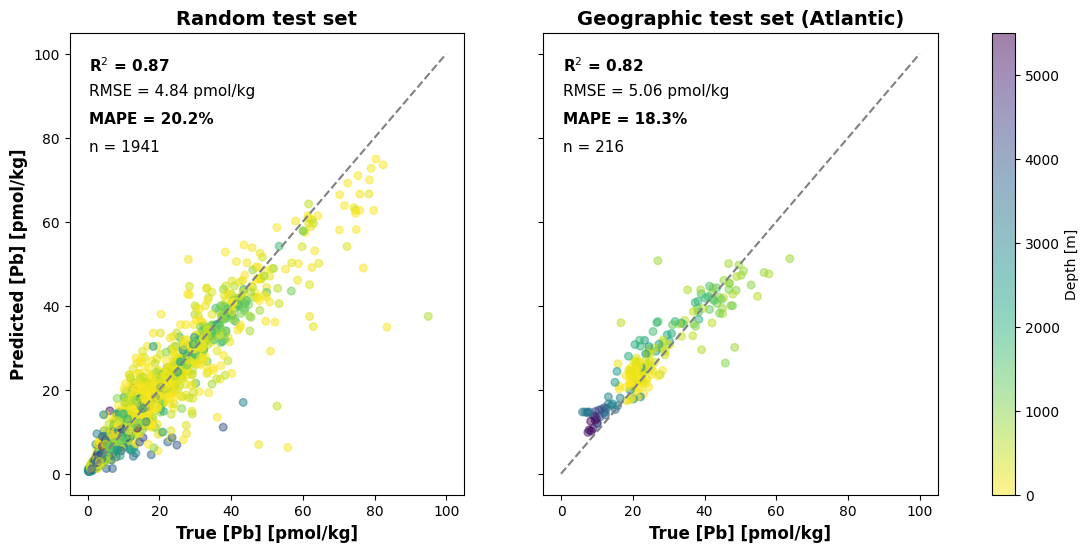

In [52]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,6))

ax[0].scatter(y_test, y_pred, c=X_test['WOD_depth'], cmap='viridis_r', vmin=0, vmax=5500, alpha=0.5, s=30)
ax[0].plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax[0].set_xlabel('True [Pb] [pmol/kg]', fontweight='bold', fontsize=12)
ax[0].set_ylabel('Predicted [Pb] [pmol/kg]', fontweight='bold', fontsize=12)
ax[0].set_title('Random test set', fontweight='bold', fontsize=14)
ax[0].text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred):.2f}', transform=ax[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[0].text(0.05, 0.89, f'RMSE = {rmse:.2f} pmol/kg', transform=ax[0].transAxes, fontsize=11, va='top', ha='left')
ax[0].text(0.05, 0.83, f'MAPE = {mape*100:.1f}%', transform=ax[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[0].text(0.05, 0.77, f'n = {len(y_test)}', transform=ax[0].transAxes, fontsize=11, va='top', ha='left')

c = ax[1].scatter(y_test_geo_NA, y_pred_geo_NA, c=X_test_geo_NA['WOD_depth'], cmap='viridis_r', vmin=0, vmax=5500, alpha=0.5, s=30)
ax[1].plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
ax[1].set_xlabel('True [Pb] [pmol/kg]', fontweight='bold', fontsize=12)
ax[1].set_title('Geographic test set (Atlantic)', fontweight='bold', fontsize=14)
ax[1].text(0.05, 0.95, f'R$^2$ = {r2_score(y_test_geo_NA, y_pred_geo_NA):.2f}', transform=ax[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[1].text(0.05, 0.89, f'RMSE = {rmse_geo_NA:.2f} pmol/kg', transform=ax[1].transAxes, fontsize=11, va='top', ha='left')
ax[1].text(0.05, 0.83, f'MAPE = {mape_geo_NA*100:.1f}%', transform=ax[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[1].text(0.05, 0.77, f'n = {len(y_test_geo_NA)}', transform=ax[1].transAxes, fontsize=11, va='top', ha='left')

fig.colorbar(c, label = 'Depth [m]', ax=ax.ravel().tolist())

plt.savefig('../../Figures/For_ms/XGBoost-bestmodel_Pb-conc_2testsets-coldepth.png', dpi = 400)

### Regional results (random test set)

In [53]:
test_set_with_pred = X_test.copy()
test_set_with_pred['y_test'] = y_test
test_set_with_pred['y_pred'] = y_pred
#test_set_with_pred['y_pred_rf'] = y_pred_rf
#test_set_with_pred

In [54]:
merged_df = pd.merge(test_set_with_pred, pb_conc_dataset_ref, left_index=True, right_index=True)
#merged_df

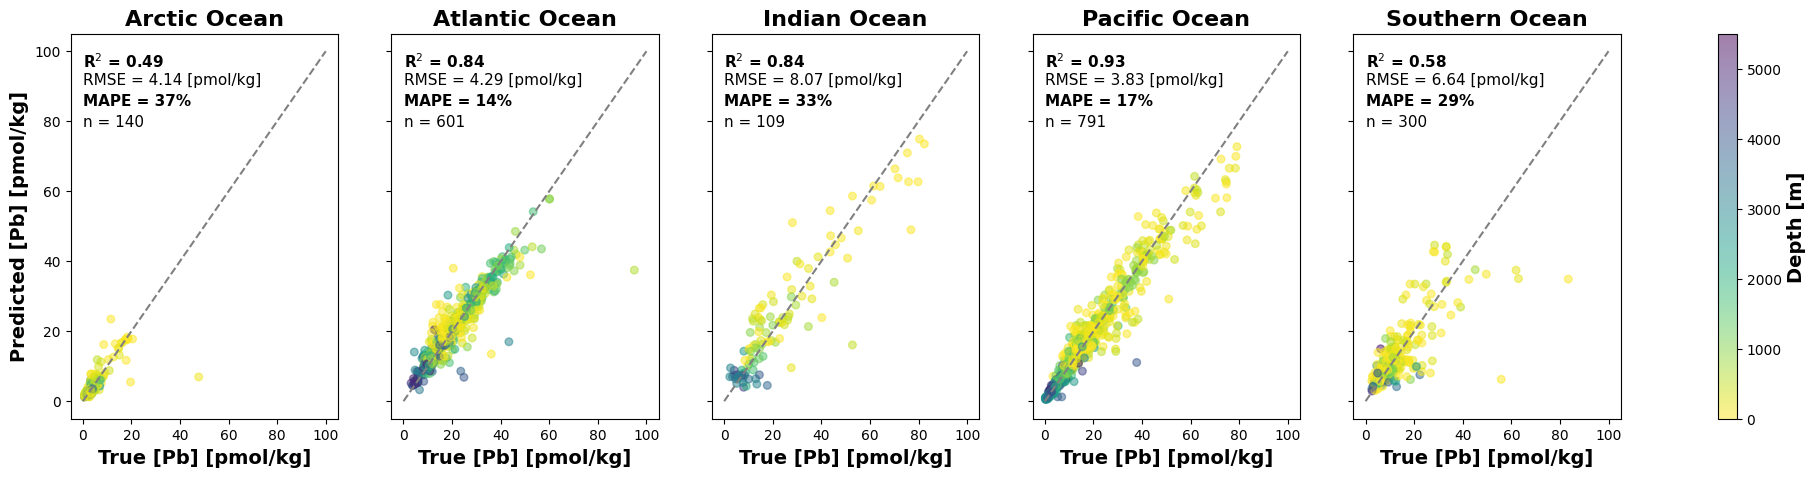

In [55]:
basins = sorted(merged_df['Ocean_basin'].unique())

fig, ax = plt.subplots(1,5, figsize=(25,5), sharey=True)

for i in range(0, len(basins)):
    c = ax[i].scatter(merged_df[merged_df['Ocean_basin'] == basins[i]]['y_test'], merged_df[merged_df['Ocean_basin'] == basins[i]]['y_pred'], c=merged_df[merged_df['Ocean_basin'] == basins[i]]['WOD_depth_x'], cmap='viridis_r', vmin = 0, vmax= 5500, alpha=0.5, s=30)
    ax[i].plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), c='grey', linestyle='--')
    ax[i].set_xlabel('True [Pb] [pmol/kg]', fontweight='bold', fontsize=14)
    if i == 0:
        ax[i].set_ylabel('Predicted [Pb] [pmol/kg]', fontweight='bold', fontsize=14)
    ax[i].set_title(f'{basins[i]} Ocean', fontweight='bold', fontsize=16)
    ax[i].text(0.05, 100, f'R$^2$ = {r2_score(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"]):.2f}', fontsize=11, fontweight='bold', va='top', ha='left')
    ax[i].text(0.05, 94, f'RMSE = {np.sqrt(mean_squared_error(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"])):.2f} [pmol/kg]', fontsize=11, va='top', ha='left')
    ax[i].text(0.05, 88, f'MAPE = {100*mean_absolute_percentage_error(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"]):.0f}%', fontsize=11, fontweight='bold', va='top', ha='left')
    ax[i].text(0.05, 82, f'n = {len(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"])}', fontsize=11, va='top', ha='left')

fig.colorbar(c, ax=ax.ravel().tolist()).set_label('Depth [m]', fontsize=14, fontweight='bold')
plt.savefig('../../Figures/For_ms/Pb_conc_predictions_XGBoost_basin-performance.png', dpi =400)
